# Togo Solar Data EDA
Exploratory Data Analysis for the Togo solar dataset (`solar-measurements_togo-davie_qc_year2.csv`).

In [8]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes



In [3]:
# Load the dataset
df = pd.read_csv('../data/solar-measurements_togo-davie_qc_year2.csv', encoding='latin1')

C:\Users\naomi.DESKTOP-T924HPN\AppData\Local\Temp\ipykernel_13416\3561597335.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/solar-measurements_togo-davie_qc_year2.csv', encoding='latin1')


In [4]:
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in key_columns:
    non_numeric = df[col][pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()]
    if not non_numeric.empty:
        print(f"Non-numeric values in {col}:\n", non_numeric.unique())

Non-numeric values in GHI:
 ['W/m²']
Non-numeric values in DNI:
 ['W/m²']
Non-numeric values in DHI:
 ['W/m²']
Non-numeric values in ModA:
 ['W/m²']
Non-numeric values in ModB:
 ['W/m²']
Non-numeric values in WS:
 ['m/s']
Non-numeric values in WSgust:
 ['m/s']


In [5]:
#Skip row with units (adjust skiprows based on inspection)
df = pd.read_csv('../data/solar-measurements_togo-davie_qc_year2.csv', encoding='latin1', skiprows=[1])

In [6]:
# Summary statistics
summary_stats = df.describe()
print(summary_stats)

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      182.779890      91.332606     115.434585     172.802929   
std       277.701199     191.253520     160.997564     259.295960   
min       -13.000000     -10.800000     -12.500000       0.000000   
25%        -3.700000      -0.300000      -3.900000       0.000000   
50%         0.000000      -0.100000      -0.100000       3.200000   
75%       315.100000      37.500000     232.200000     291.125000   
max      1427.000000     925.000000     950.000000    1297.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      169.290888      26.949324      82.856382       1.723609   
std       254.930392       3.325204      14.038370       1.262782   
min         0.000000      18.200000      16.100000       0.000000   
25%         0.000000      24.4000

In [7]:
# Missing values
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100
print("Missing Values:\n", missing_values)
print("\nColumns with >5% missing values:\n", missing_percent[missing_percent > 5])

Missing Values:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Columns with >5% missing values:
 Comments    100.0
dtype: float64


In [ ]:
# Compute Z-scores
z_scores = df[key_columns].apply(zscore, nan_policy='omit')
# Flag outliers (|Z| > 3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of rows with outliers: {outliers.sum()}")

In [10]:
# Drop columns with >50% missing values
df = df.loc[:, df.isna().mean() < 0.5]

In [11]:
# Export cleaned data
df.to_csv('../data/togo_clean.csv', index=False)

In [12]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

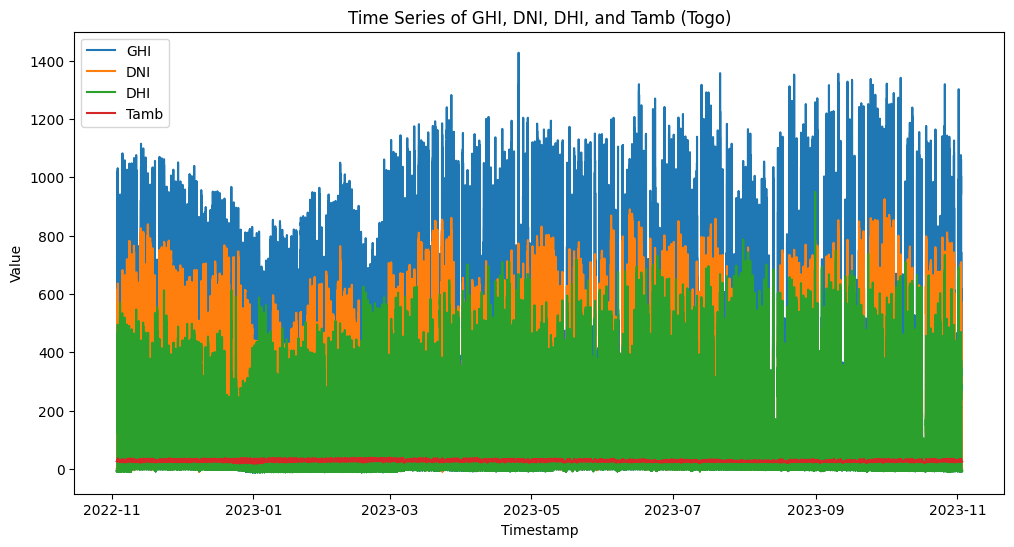

In [14]:
#Line plots
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI')
plt.plot(df['Timestamp'], df['DNI'], label='DNI')
plt.plot(df['Timestamp'], df['DHI'], label='DHI')
plt.plot(df['Timestamp'], df['Tamb'], label='Tamb')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of GHI, DNI, DHI, and Tamb (Togo)')
plt.legend()
plt.show()

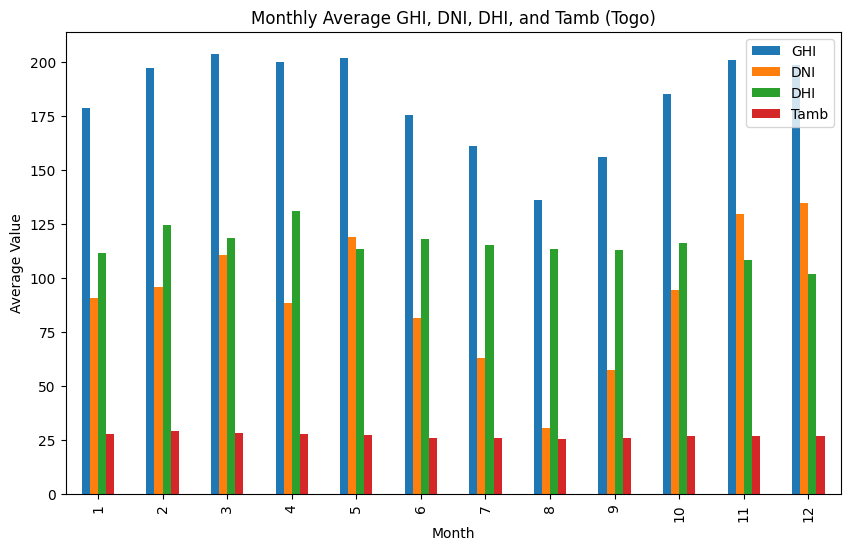

In [15]:
df['Month'] = df['Timestamp'].dt.month
monthly_stats = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Create bar chart
monthly_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Average GHI, DNI, DHI, and Tamb (Togo)')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.show()

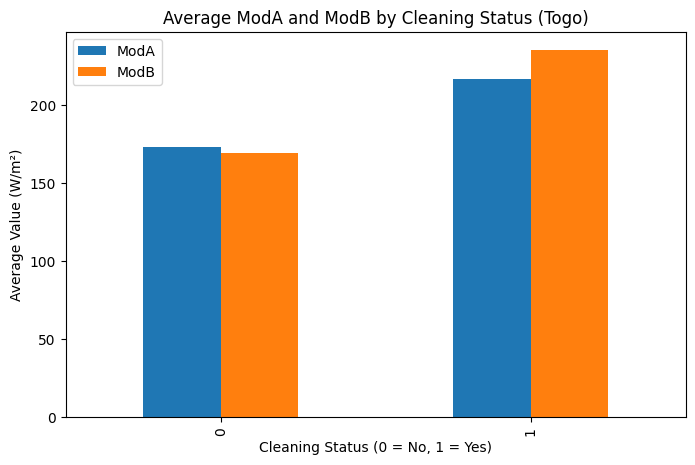

In [16]:
# Group by Cleaning flag
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot bar chart
cleaning_impact.plot(kind='bar', figsize=(8, 5))
plt.title('Average ModA and ModB by Cleaning Status (Togo)')
plt.xlabel('Cleaning Status (0 = No, 1 = Yes)')
plt.ylabel('Average Value (W/m²)')
plt.show()

Cleaning increases ModA and ModB, indicating reduced soiling.

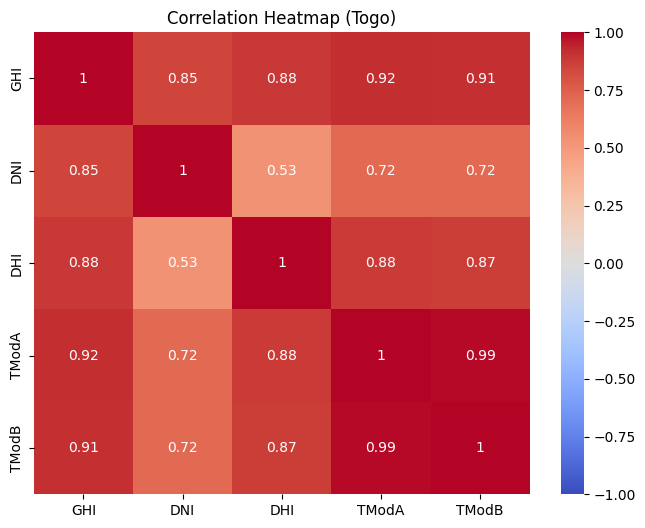

In [17]:
# Correlation matrix
correlation_matrix = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Togo)')
plt.show()

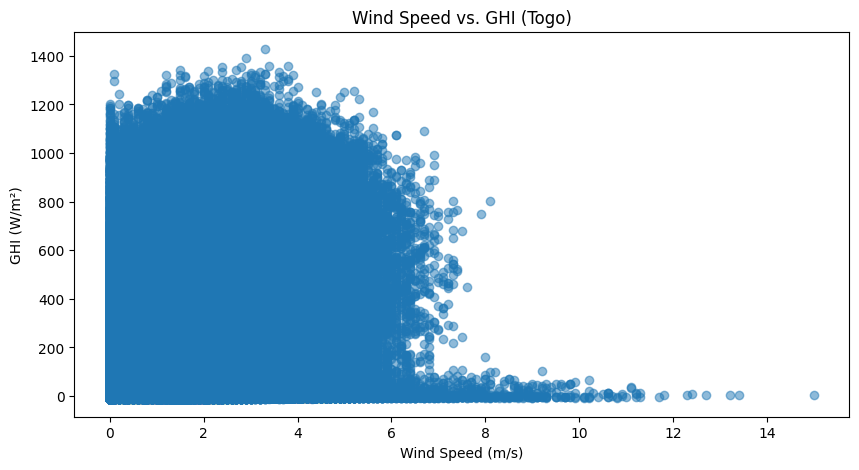

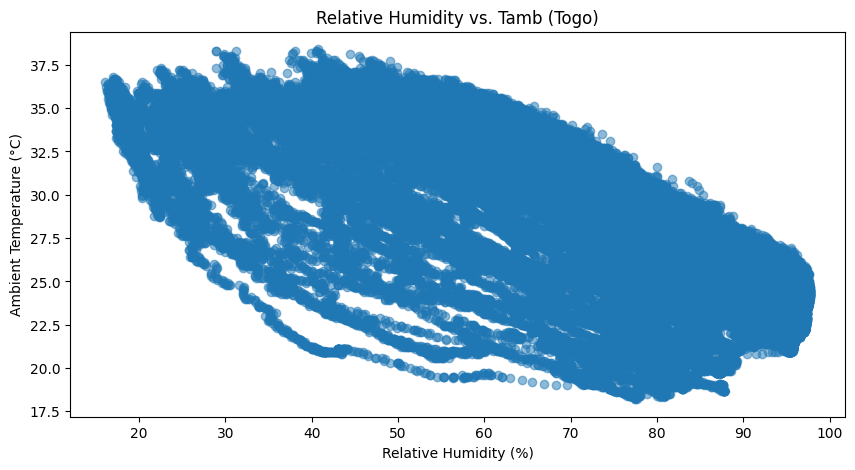

In [18]:
# Scatter plot: Wind Speed vs. GHI
plt.figure(figsize=(10, 5))
plt.scatter(df['WS'], df['GHI'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Speed vs. GHI (Togo)')
plt.show()

# Scatter plot: Relative Humidity vs. Tamb
plt.figure(figsize=(10, 5))
plt.scatter(df['RH'], df['Tamb'], alpha=0.5)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Relative Humidity vs. Tamb (Togo)')
plt.show()

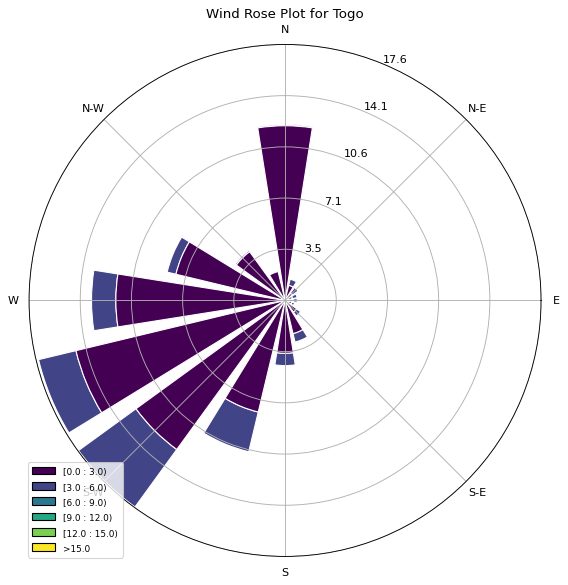

In [19]:
# Wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot for Togo')
plt.show()

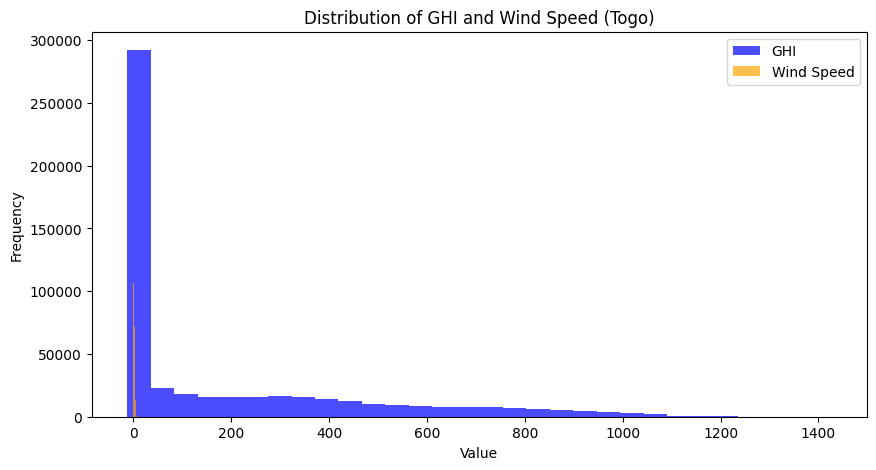

In [20]:
# Histograms
plt.figure(figsize=(10, 5))
plt.hist(df['GHI'], bins=30, alpha=0.7, label='GHI', color='blue')
plt.hist(df['WS'], bins=30, alpha=0.7, label='Wind Speed', color='orange')
plt.legend()
plt.title('Distribution of GHI and Wind Speed (Togo)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()